## Session3 - playground (optional)

In [15]:
# Usual imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
    
# Network building and training
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

### Load and prepare the dataset / データを読み込んで準備する

In [16]:
from mnist_loader import MNISTImageLoader
mnist_image_loader = MNISTImageLoader(43)
X, y = mnist_image_loader.samples(70000)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.5)

# Limit the values in [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (35000, 28, 28, 1)
Testing set size: (35000, 28, 28, 1)


<div style="background-color: #FFDDBB; padding: 10px;">
<b>REMINDER</b>: If you are getting strange errors when executing code with neural networks, make sure that you stopped or restarted the kernels in all other notebooks!
    
<b>注意</b>：ニューラルネットワークのコードを実行しているときに見知らぬエラーが発生した場合は、他のすべてのノートブックでカーネルを停止または再起動したかを確認してください！
</div>


## OPTIONAL 1
Create a CNN to recognize MNIST digits. You can re-use the example CNN.
<br>
You should name your network `network`.


MNISTの手書き数字を認識するCNNを作成してください。mainノートブックのサンプルCNNを再利用しても構いません。
<br>
ネットワークの変数の名前は`network`にしてください。

In [17]:
input_shape = X_train[0].shape
img_input = Input(shape = input_shape, name='input')
input_shape

(28, 28, 1)

In [18]:
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv1')(img_input)
conv2 = Conv2D(64, (3, 3), activation='relu', name='conv2')(conv1)
pool = MaxPooling2D(pool_size=(2, 2), name='pool')(conv2)
dp1 = Dropout(0.25)(pool)
fl = Flatten()(dp1)
fc1 = Dense(128, activation='relu', name="fc1")(fl)
dp2 = Dropout(0.5)(fc1)
fc2 = Dense(10, activation='softmax', name="fc2")(dp2)
network = Model(img_input, fc2, name='CNN_classification')

In [19]:
network.summary()

Model: "CNN_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 64)        18496     
_________________________________________________________________
pool (MaxPooling2D)          (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)        

## OPTIONAL 2
- Train your CNN using part of the training set as validation data 
- Plot the evolution of the loss functions
- Test the performance on the testing set (confusion matrix and accuracy)


- トレーニングセットの一部を検証データとして使用してCNNをトレーニングする
- 損失関数の進化をプロットする
- テストセットでパフォーマンスをテストする（混乱マトリックスと精度）

In [20]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

network.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['acc'])

H = network.fit(X_train, y_train_one_hot, batch_size=100, epochs=20, validation_data=(X_test, y_test_one_hot), verbose=1)

Train on 35000 samples, validate on 35000 samples
Epoch 1/20
35000/35000 [==============================] - 35s 1ms/sample - loss: 0.2850 - acc: 0.9125 - val_loss: 0.0706 - val_acc: 0.9786
Epoch 2/20
35000/35000 [==============================] - 35s 1ms/sample - loss: 0.1400 - acc: 0.9576 - val_loss: 0.0625 - val_acc: 0.9807
Epoch 3/20
35000/35000 [==============================] - 34s 973us/sample - loss: 0.1206 - acc: 0.9638 - val_loss: 0.0673 - val_acc: 0.9813
Epoch 4/20
35000/35000 [==============================] - 34s 974us/sample - loss: 0.1144 - acc: 0.9657 - val_loss: 0.0546 - val_acc: 0.9845
Epoch 5/20
35000/35000 [==============================] - 34s 977us/sample - loss: 0.0992 - acc: 0.9693 - val_loss: 0.0520 - val_acc: 0.9847
Epoch 6/20
35000/35000 [==============================] - 34s 977us/sample - loss: 0.0997 - acc: 0.9702 - val_loss: 0.0540 - val_acc: 0.9863
Epoch 7/20
35000/35000 [==============================] - 34s 979us/sample - loss: 0.0955 - acc: 0.9711 - va

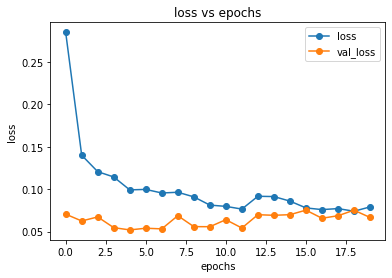

In [21]:
plt.plot(H.history['loss'], 'o-',label="loss")
plt.plot(H.history['val_loss'], 'o-', label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss vs epochs")
plt.legend();

## OPTIONAL 3
- Test hand written digit recognition using the next cell
- Evaluate the performance of the network


- 次のセルを使用して手書き数字の認識をテストする
- ネットワークのパフォーマンスを評価する

In [22]:
import ipywidgets as widgets
import jupyter_drawing_pad as jd
    
jdp = jd.CustomBox()
draw_pad = jdp.drawing_pad
clear_btn = jdp.children[1].children[1]

out = widgets.Output(layout=widgets.Layout(width='400px'))

@out.capture() 
def w_CB(change):
    from scipy.signal import convolve2d
    from cv2 import resize, INTER_CUBIC, cvtColor, COLOR_RGB2GRAY

    data = change['new']
    if len(data[0]) > 2:
        # Get strokes information
        x = np.array(data[0])
        y = np.array(data[1])
        t = np.array(data[2])

        # assuming there is at least 200ms between each stroke 
        line_breaks = np.where(np.diff(t) > 200)[0]
        # adding end of array
        line_breaks = np.append(line_breaks, t.shape[0])
        
        # Plot to canvas
        from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        ax = fig.gca()

        # plot all strokes
        plt.plot(x[:line_breaks[0]], y[:line_breaks[0]], color='black', linewidth=4)
        for i in range(1, len(line_breaks)):
            plt.plot(x[line_breaks[i-1]+1 : line_breaks[i]], y[line_breaks[i-1]+1 : line_breaks[i]], color='black', linewidth=4)
        
        plt.xlim(0,460)
        plt.ylim(0,250)
        plt.axis("off")
        
        canvas.draw()       # draw the canvas, cache the renderer

        # convert to numpy array 
        imageflat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        # not sure why this size...
        image = np.reshape(imageflat,(288, 432, 3))
        
        # Cut the part containing the writting
        ind = np.where(image<255)      
        
        D0 = ind[0].max() - ind[0].min() 
        D1 = ind[1].max() - ind[1].min() 
        
        C0 = int(0.5 * (ind[0].max() + ind[0].min()))
        C1 = int(0.5 * (ind[1].max() + ind[1].min()))

        if D0 > D1:
            D = D0
        else:
            D = D1
        
        L = int(D / 2.0) + 20
        image = image[C0 - L : C0 + L ,  C1 - L : C1 + L, :]
        
        # Convert to gray
        image = 255 - cvtColor(image, COLOR_RGB2GRAY)
        
        # Low pass filter and resize
        k = 12
        I = convolve2d(image, np.ones((k,k))/k**2.0, mode="same")      
        
      
        
        
        # Resize with opencv 
        I = resize(I, dsize=(28, 28), interpolation=INTER_CUBIC)
        
        # Clip in [0, 1]
        I = I / I.max()
        I = I * 3.0
        I = I.clip(0, 1)
                    
        # Apply the classifier
        y_pred_one_hot = network.predict(I[np.newaxis, :, :, np.newaxis])
        y_prediction = np.argmax(y_pred_one_hot)
        v = np.max(y_pred_one_hot)    
        
        title = "Prediction: {} ({:.02f})".format(y_prediction, v)    
        
        # draw the converted image
        plt.clf()
        #plt.imshow(I, aspect='equal', cmap = mpl.cm.binary, interpolation='none')
        plt.imshow(I, cmap = mpl.cm.binary, interpolation='none')
        plt.title(title)
        #plt.axis("off")
        #plt.colorbar()

              
        plt.show()

        # To erase after tracing
        #change['owner'].data = [[], [], []]
        
        # Schedule for clearing
        out.clear_output(wait=True)
    else:
        pass
        
draw_pad.observe(w_CB, names='data')

hb = widgets.HBox([draw_pad, clear_btn, out])
display(hb)